## Clustering items

There is a csv file called "item_features" in which there is information about the items available for purchase on the H & M web site. A category can be any attribute, the type of sleeve of a T-shirt, whether a pair of pants is long or short, or the color of a sweatshirt. Also indicated is the category value, which is the value of the attribute to which the category refers. For example, if the category is the color of the T-shirt, the value may be red. We have no way of understanding what is what, since item, category and value are referenced by IDs. In order to obtain valuable information from the items in the subsequent training of the model, we will have to identify what type of item it is, so that we can group the items by clusters. This can be done through an unsupervised learning process called clustering. We are going to try to identify which clusters exist and which items are in each of them, just from the data present in the mentioned file.

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns

In [48]:
purchases = pd.read_csv('train_purchases.csv')
sessions = pd.read_csv('train_sessions.csv')
features = pd.read_csv('item_features.csv')

In [33]:
features_ones = features.copy()
features_ones["feature_value_id"]=1
features_ones = features_ones.dropna()
features_ones = features_ones.pivot_table(values='feature_value_id', index='item_id', columns='feature_category_id', aggfunc='first')
features_ones = features_ones.replace(np.nan, 0)
features_matrix = features.pivot_table(values='feature_value_id', index='item_id', columns='feature_category_id', aggfunc='first')

features_ones.head(10)

feature_category_id,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
item_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
8,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
9,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
10,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
13,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0


In [35]:
features_scaled = features_ones

In [49]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

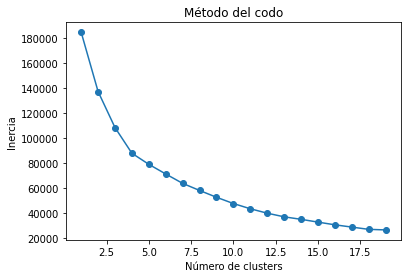

In [36]:
# Elbow method to find the optimal number of clusters 
import matplotlib.pyplot as plt

wcss = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i,max_iter=300,n_init=10,random_state=0)
    km=kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)
plt.figure()
plt.plot(range(1,20),wcss, marker="o")

plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')

plt.show()

Se puede ver un 'codo' con 4 clústeres, habrá que comprobar con un análisis de la silueta si es coherente escoger ese número.

In [37]:
features_series=pd.Series(features_scaled.index)

In [38]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


def silhouette_analysis(df, cluster_labels,n,clustering_type,heading):
    
    plt.figure(figsize=(15,10))
    ax= plt.subplot()
    ax.set_ylim([0, len(df) + (n + 1) * 50])
    dictofhobbies={i:cluster_labels[i] for i in range(0,len(cluster_labels))}
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    if clustering_type == 'Kmeans':
        metrics='euclidean'
    if clustering_type == 'Agglomerative':
        metrics='euclidean'
    if clustering_type == 'GaussianMixture':
        metrics='mahalanobis'
    silhouette_avg = silhouette_score(df, cluster_labels,metric=metrics)
    
    print("For n_clusters =", n,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df, cluster_labels)
    
   
    yticks=[]
    ylabels=[]
    y_lower = 10
    for i in range(n):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        silhouette_labels=[hobby for hobby,cluster_label in dictofhobbies.items() if cluster_label==i ]
        zipped_values=dict(zip(silhouette_labels,ith_cluster_silhouette_values))      
        #sorted(zipped_values,key=lambda x:x1])
        new_zipped_values=sorted(zipped_values.items(), key=lambda x: x[1])
        ith_cluster_silhouette_values.sort()
        #print("ith_cluster_silhouette_values::",len(ith_cluster_silhouette_values))
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        #print("yupper is::",y_upper)
        color = cm.nipy_spectral(float(i) / n)
        pos=np.arange(y_lower, y_upper)
       
        ax.barh(pos,ith_cluster_silhouette_values,height=1.0,color=color, edgecolor="none")
               
        yticks.extend(pos)
        ylabels.extend(labels[0] for labels in new_zipped_values)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
       
        # Compute the new y_lower for next plot
        y_lower = y_upper + 50  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Clusters")
    
    
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    hobbies_labels=[]
    for y in ylabels:
        hobbies_labels.append(features_series[y])
    
    #ax.set_yticks(yticks)
    #ax.set_yticklabels(hobbies_labels, fontSize=8)  
    ax.set_xticks([-0.1, 0,0.1, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for " ,heading, "with n_clusters = %d" % n),
                 fontsize=14, fontweight='bold')

plt.show()

Tras el análisis que hemos llevado a cabo de que número de componentes es necesario, probamos a obtener los valores de los average silhouette score para cada número de clusters del 2 al 10. 

PCA for components=16
For n_clusters = 2 The average silhouette_score is : 0.27740755563614417
For n_clusters = 3 The average silhouette_score is : 0.3338593491647794
For n_clusters = 4 The average silhouette_score is : 0.37921809967507686
For n_clusters = 5 The average silhouette_score is : 0.3648480030034613
For n_clusters = 6 The average silhouette_score is : 0.373790987204069
For n_clusters = 7 The average silhouette_score is : 0.40335512938551077
For n_clusters = 8 The average silhouette_score is : 0.4448251709325846
For n_clusters = 9 The average silhouette_score is : 0.47271535535555004


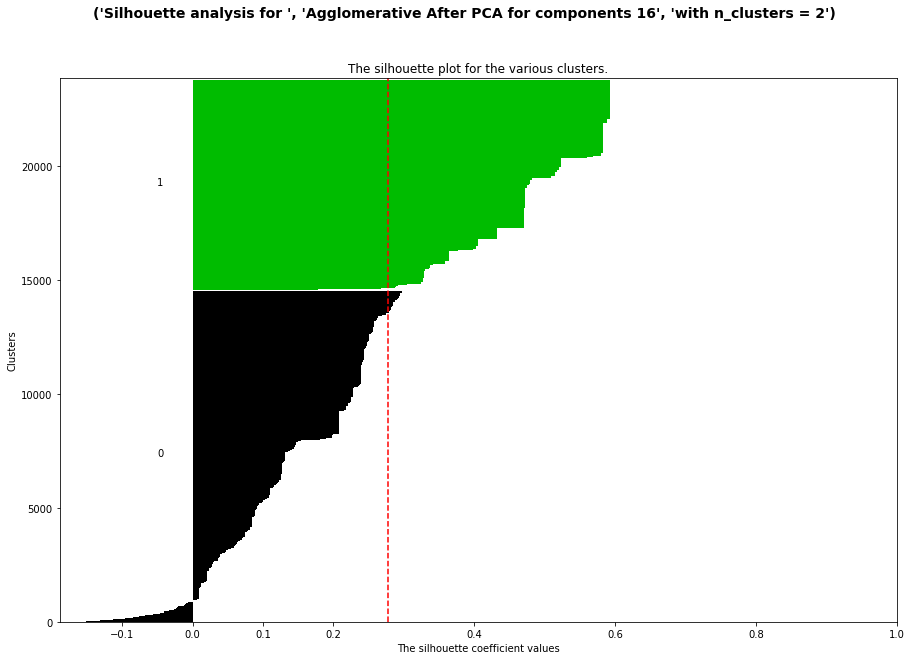

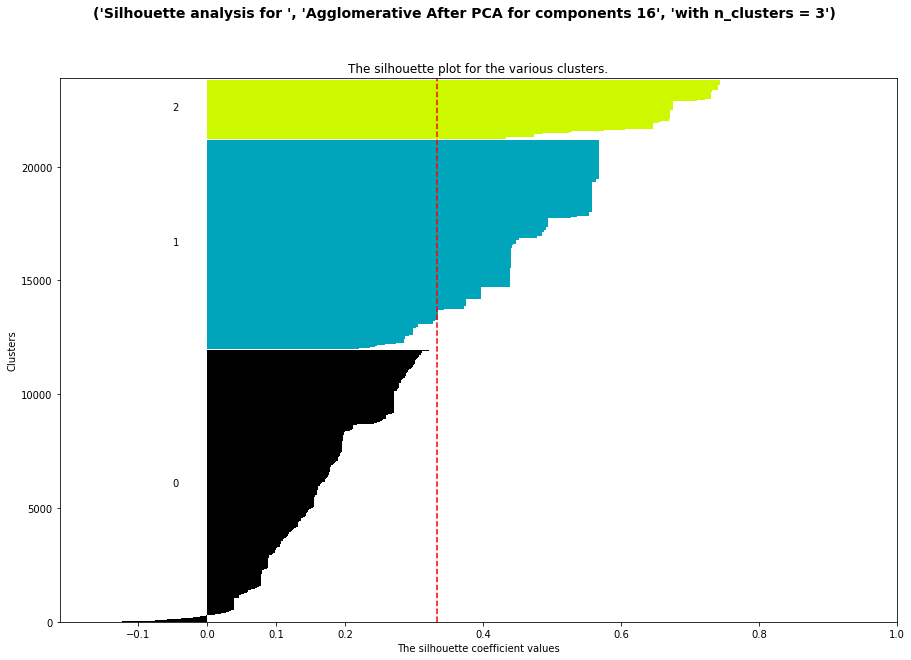

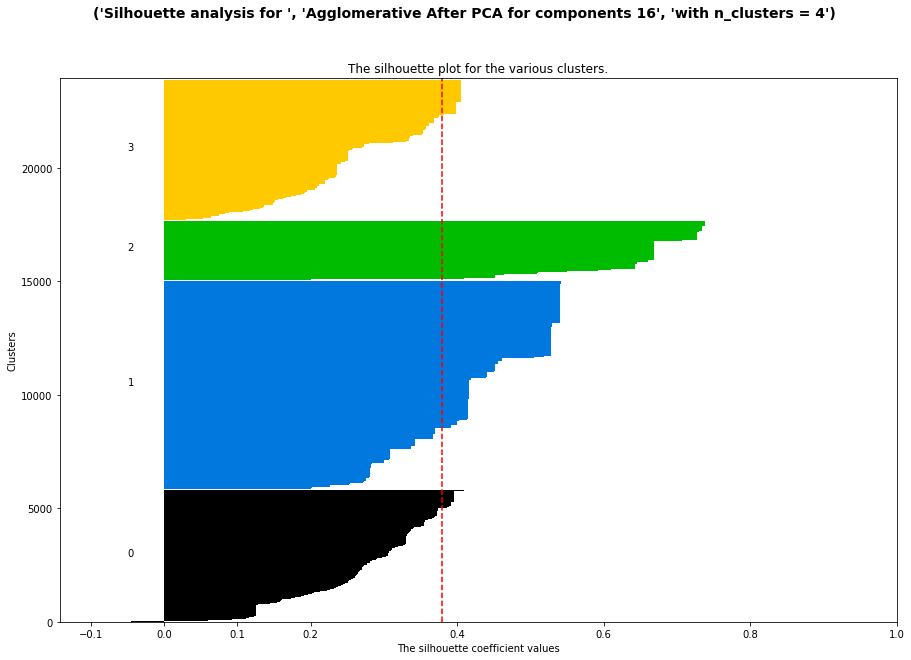

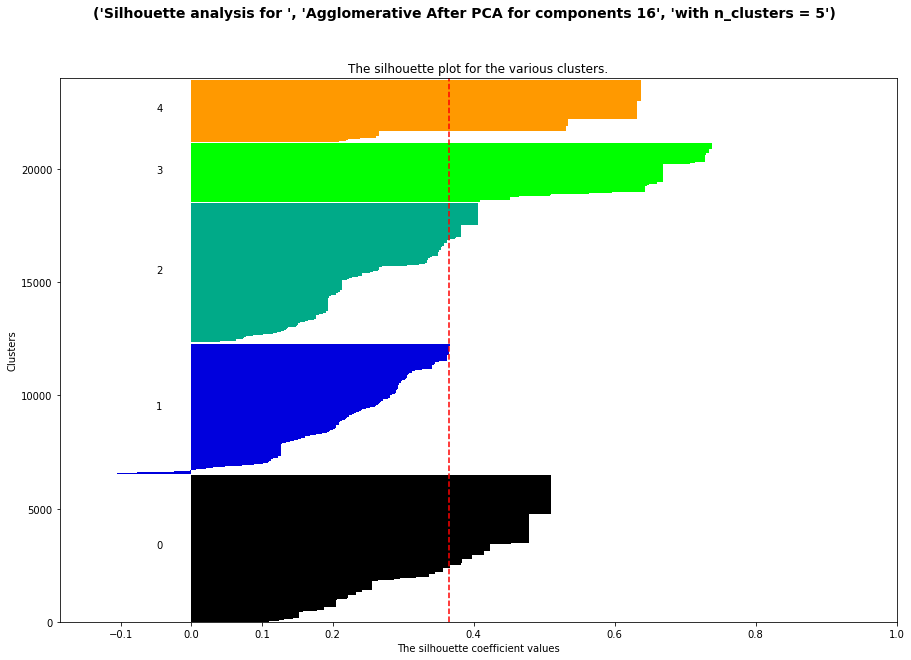

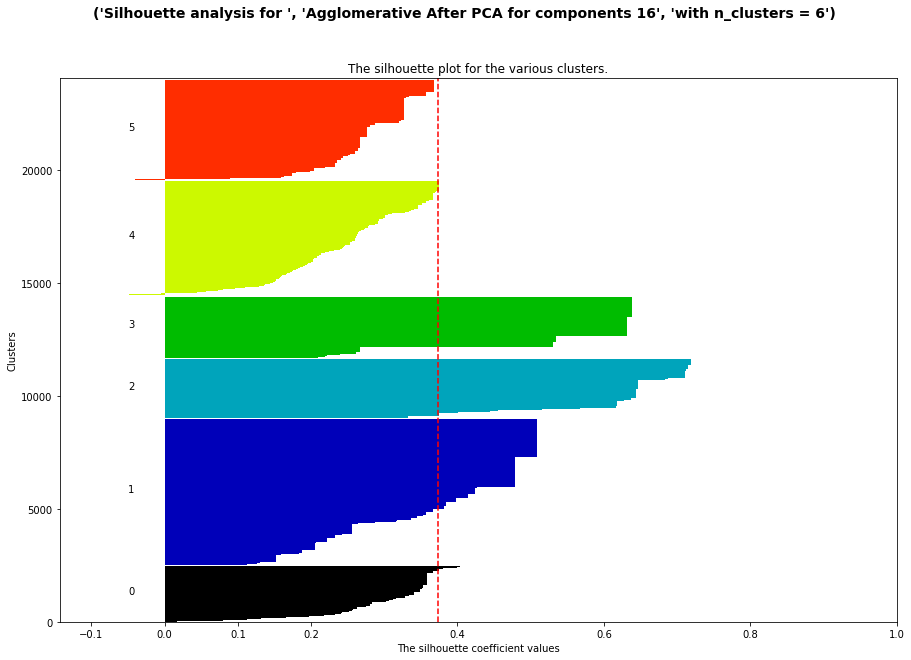

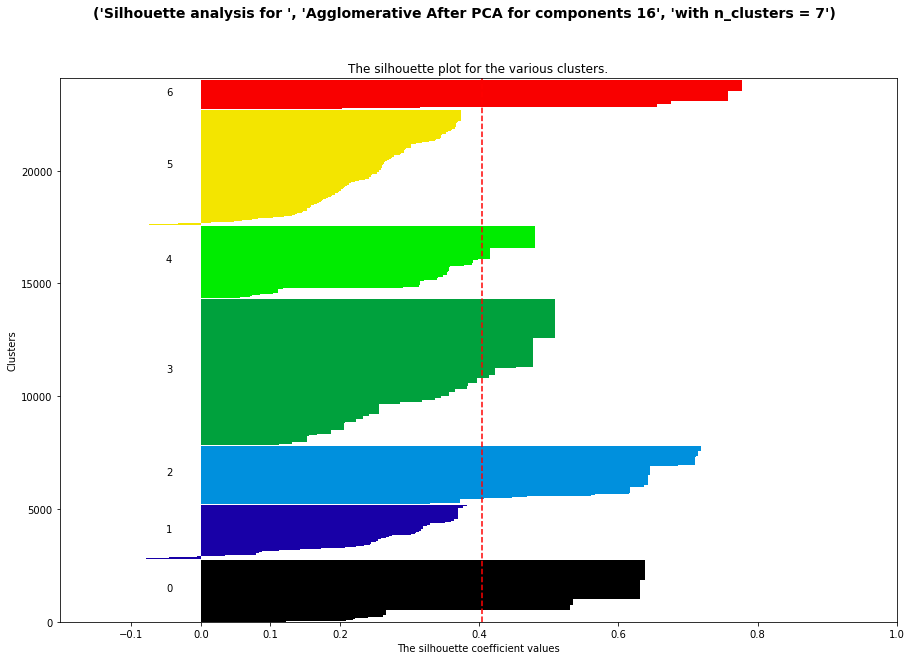

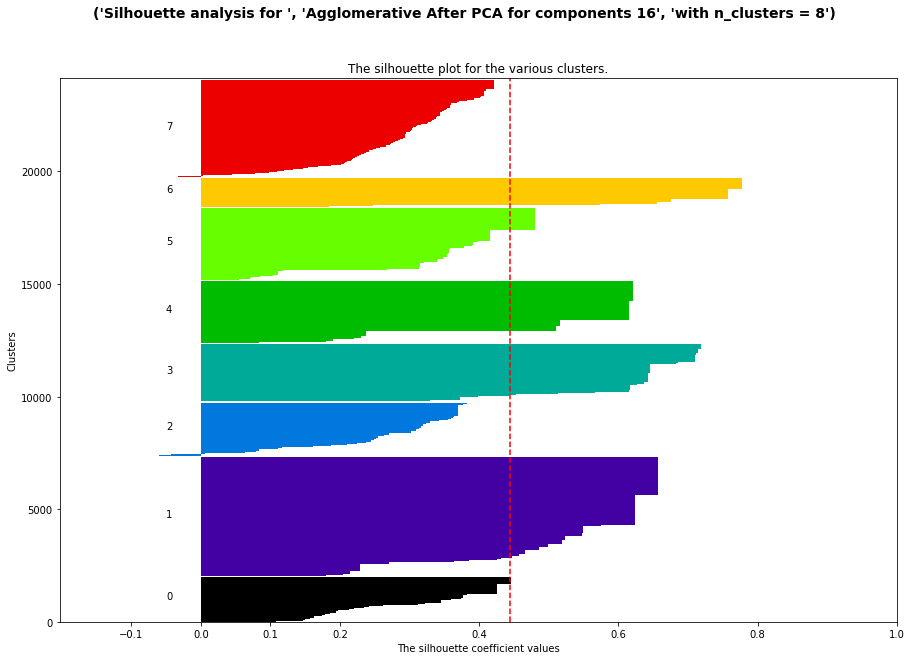

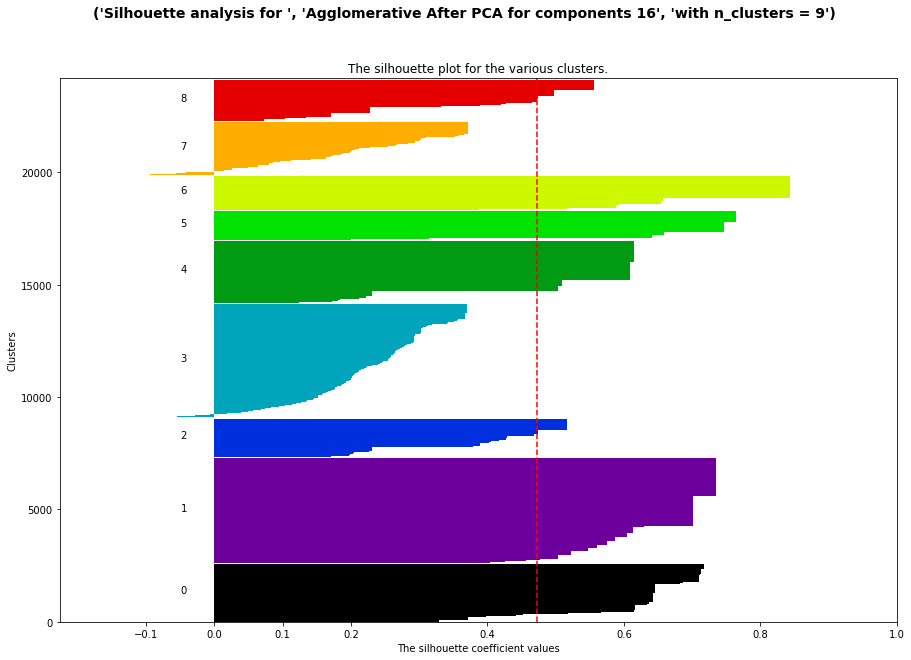

In [39]:
#running PCA with kmeans 

from sklearn.decomposition import PCA

for n_comp in [16]:
    print("PCA for components=%d"%n_comp)
    pca_km=PCA(n_components=n_comp)
    df_reduced=pca_km.fit_transform(features_scaled)
    
    
    for n_clust in range(2,10):
        kmeans_red_pca=KMeans(n_clusters=n_clust)
        reduced_cluster_labels=kmeans_red_pca.fit_predict(df_reduced)
        centers_km=kmeans_red_pca.cluster_centers_
        silhouette_analysis(df_reduced,reduced_cluster_labels,n_clust,'Agglomerative','Agglomerative After PCA for components %d' %n_comp)

In [40]:
n_clusts = 4

In [41]:
def visualize_clusters(to_plot,n_clusters,method,centers = []):
    
    plt.figure(figsize=(15,8))
    ax=plt.subplot()

    colors=['red','green','blue','orange','yellow','purple','brown','black','magenta','cyan']

    for n_clusters in range(n_clusters):
        
        #colors = cm.nipy_spectral((to_plot['Cluster_pred']== n_clusters).astype(float) / n_clusters)
        #colors=['red','green','blue','orange','yellow','purple']
        
        ax.scatter(to_plot[to_plot['Cluster_pred']==n_clusters].iloc[:, 1],to_plot[to_plot['Cluster_pred']==n_clusters].iloc[:, 2],
                   marker='.', s=80, lw=0, alpha=0.7,
                    c=colors[n_clusters], edgecolor='black', label='Cluster %d'%n_clusters)

            
            # Draw white circles at cluster centers
    for i, c in enumerate(centers):

        ax.scatter(c[0], c[1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')
        ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=80, edgecolor='k')
                                
    ax.set_title("The visualization of the clustered data using the " + method + " method.")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    plt.legend()    
    plt.show()


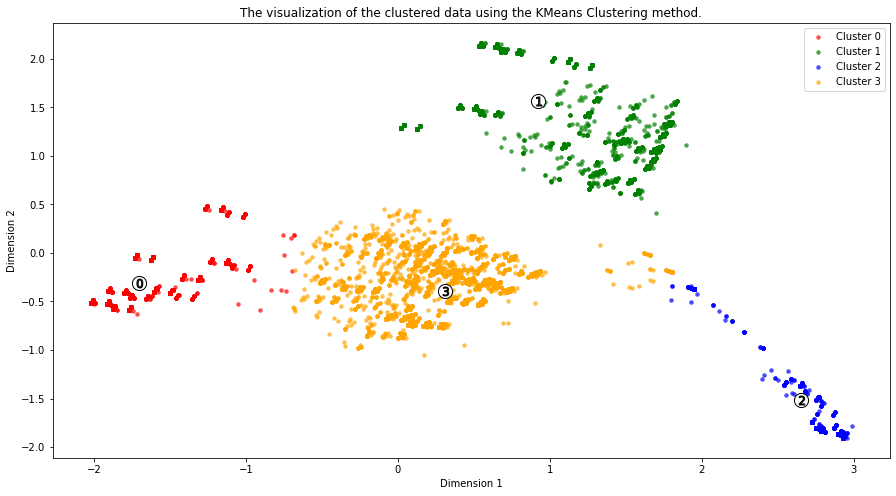

In [42]:
#KMEANS

#visualizing the 5 clusters in 2 dimensions with 2 principal componenets
#reducing data to 2 prinicipal components
pca_2comp=PCA(n_components=2)
df_reduced_2comp=pca_2comp.fit_transform(features_scaled)

# running Kmeans for 5 clusters on 2 PC's
kmeans_pca_2comp=KMeans(n_clusters=n_clusts)
reduced_cluster_labels_2comp=kmeans_pca_2comp.fit_predict(df_reduced_2comp)
centers_2comp=kmeans_pca_2comp.cluster_centers_

#creating dataframes for cluster labels and 2 PC's
predictions=pd.DataFrame(reduced_cluster_labels_2comp,columns=['Cluster_pred'])
reduced_df_2comp=pd.DataFrame(np.round(df_reduced_2comp,n_clusts),columns=['Dimension 1','Dimension 2'])

# concatanete the above two dfs
to_plot=pd.concat([predictions,reduced_df_2comp], axis=1)

visualize_clusters(to_plot,n_clusts,"KMeans Clustering",centers_2comp)

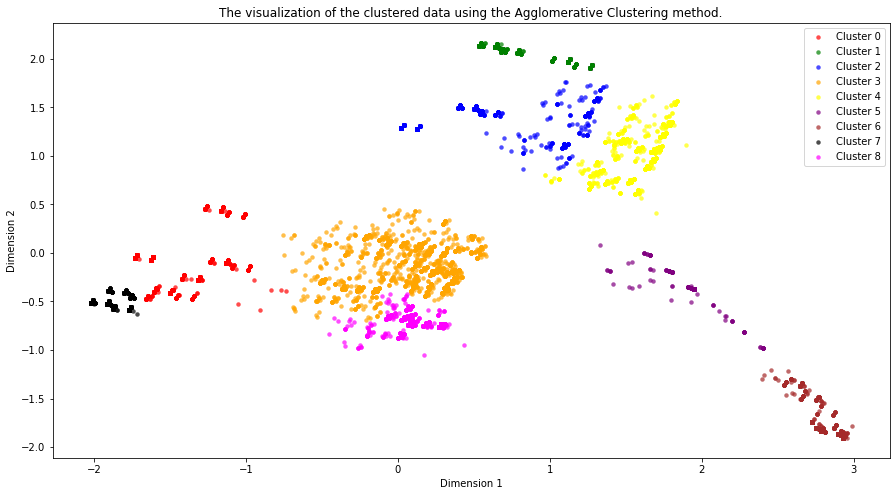

In [43]:
#AgglomerativeClustering

#visualizing the 5 clusters in 2 dimensions with 2 principal componenets
#reducing data to 2 prinicipal components
pca_2comp=PCA(n_components=2)
df_reduced_2comp=pca_2comp.fit_transform(features_scaled)

# running Kmeans for 5 clusters on 2 PC's
kmeans_pca_2comp=AgglomerativeClustering(n_clusters=10)
reduced_cluster_labels_2comp=kmeans_pca_2comp.fit_predict(df_reduced_2comp)
#centers_2comp=kmeans_pca_2comp.cluster_centers_

#creating dataframes for cluster labels and 2 PC's
predictions=pd.DataFrame(reduced_cluster_labels_2comp,columns=['Cluster_pred'])
reduced_df_2comp=pd.DataFrame(np.round(df_reduced_2comp,10),columns=['Dimension 1','Dimension 2'])

# concatanete the above two dfs
to_plot=pd.concat([predictions,reduced_df_2comp], axis=1)

visualize_clusters(to_plot,9,"Agglomerative Clustering")

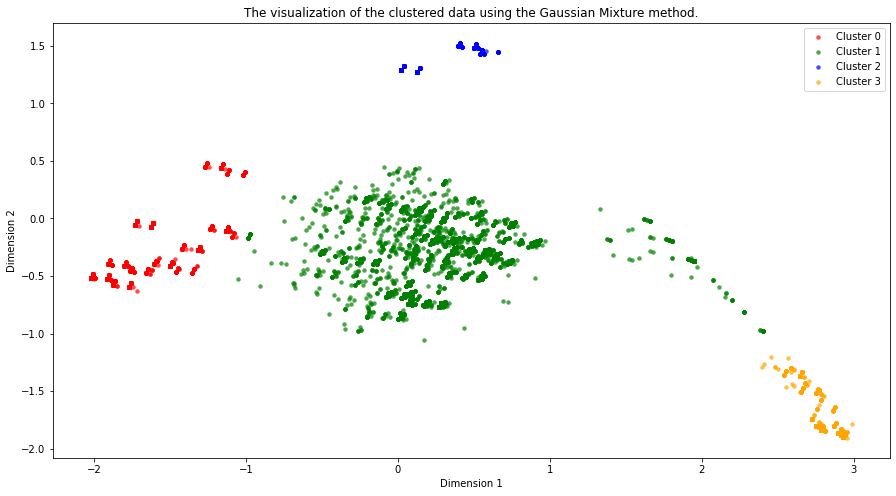

In [44]:
#GMixture

#visualizing the 5 clusters in 2 dimensions with 2 principal componenets
#reducing data to 2 prinicipal components
pca_2comp=PCA(n_components=2)
df_reduced_2comp=pca_2comp.fit_transform(features_scaled)

# running Kmeans for 5 clusters on 2 PC's
kmeans_pca_2comp=GaussianMixture(n_components=5)
reduced_cluster_labels_2comp=kmeans_pca_2comp.fit_predict(df_reduced_2comp)
#centers_2comp=kmeans_pca_2comp.cluster_centers_

#creating dataframes for cluster labels and 2 PC's
predictions=pd.DataFrame(reduced_cluster_labels_2comp,columns=['Cluster_pred'])
reduced_df_2comp=pd.DataFrame(np.round(df_reduced_2comp,4),columns=['Dimension 1','Dimension 2'])

# concatanete the above two dfs
to_plot=pd.concat([predictions,reduced_df_2comp], axis=1)

visualize_clusters(to_plot,4,"Gaussian Mixture")

In [45]:
print(predictions)

       Cluster_pred
0                 4
1                 0
2                 0
3                 1
4                 0
...             ...
23686             0
23687             3
23688             0
23689             1
23690             1

[23691 rows x 1 columns]


In [46]:
cluster_assign = predictions.loc[to_plot.index,'Cluster_pred']
cluster_assign= cluster_assign.to_frame()

cluster_assign["item_id2"]=np.unique(features[['item_id']].values).tolist()
#print(np.unique(features[['item_id']].values).tolist())
cluster_assign.head()
cluster_assign.to_csv('cluster_assign.csv')